# Project Team Members:
   **Andres Baez, acbaez@ucsd.edu, A92112700**
   
   **Catherine Kim, cyk020@ucsd.edu, A12598619**
   
   **Eric Richards, eorichar@ucsd.edu, A12724500**
   
   **Ronald Tun, Rtun@ucsd.edu, A12458764 **
   
   **Janica Kann, jkann@ucsd.edu, A13734650**
   
   **Myung Sun Kim, msk024@ucsd.edu, A12870165 **

# 0. Imports That Allow Our Project to Work: 

In [1]:
#import necessary packages
import json
import pandas as pd
import numpy as np
from textblob import TextBlob
import time
import matplotlib as mpl 
import matplotlib.pyplot as plt 

import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# 1. Introduction and Background:

From personal experience using Yelp, we have noticed that users tend to leave more opinionated reviews as they gain more experience reviewing restaurants.  Through this observation, we became curious if users leave “critical” reviews as time passes. In this context, we define the word “critical” as users leaving more reviews with a negative connotation.

**Research Question:** Do Yelp users become more critical in their reviews after becoming “Elite” members?

**Hypothesis:** After becoming Elite members, users will become more critical in their Yelp reviews compared to their earlier reviews. The Elite status can be used as an indicator of whether a user will become more likely to leave a critical review. 


# 2. Methods:

Within Yelp’s academic dataset are 6 .json files, we will be using 2 (review.json, user.json) files for this project. They contain full review text data including the user_id that wrote the review and the business_id the review is written for, as well as user data such as the user's friend mapping and associated metadata.
We combined user.json and review.json by matching the 22 character unique user id for each review in review.json to the same 22 character user id in user.json. This will match a review (a text string) to the corresponding user profile data (including whether they are an elite user) available in user.json.

We cleaned this, this, and this from this dataset. We utilized this, this, and this from this dataset. 
We’re looking to see if there is a relationship between the time a user becomes an elite member to how they leave more critical reviews after this status change. We’ll be comparing how the user left reviews prior to becoming an elite member to how the user leaves reviews after the user becomes an Elite member to see if there is a difference.


In [2]:
#Read in both data frames
#Set filename and read through review JSON file line by line
if False:
    filename_review = "/Users/andresbaez/Desktop/COGS108_Project/yelp_dataset/review.json"
    #Create dataframe that will contain review data
    df_review = pd.DataFrame()
    #go through each JSON object and create a dictionary out of its key-value pairs
    st = time.time()
    with open(filename_review,'r') as f:
        for line in f:
            data = json.loads(line)
            #append each JSON object to df_review
            df_review = df_review.append(data, ignore_index=True)       
            if (time.time() - st) > 60:
                break
    df_review.to_csv("/Users/andresbaez/Desktop/COGS108_Project/yelp_dataset/review.csv")
    #Set filename and read through user JSON file line by line
    filename_users = "/Users/andresbaez/Desktop/COGS108_Project/yelp_dataset/user.json"
    #Create dataframe that will contain user data
    df_users = pd.DataFrame()
    #go through each JSON object and create a dictionary out of its key-value pairs
    st = time.time()
    with open(filename_users,'r') as f:
        for line in f:
            data = json.loads(line)
            #append each JSON object to df_users
            df_users = df_users.append(data, ignore_index=True)
            if (time.time() - st) > 60:
                break
    df_users.to_csv("/Users/andresbaez/Desktop/COGS108_Project/yelp_dataset/user.csv")

**Dropping **

In [ ]:
#Read newly exported CSV files into dataframe
df_review = pd.read_csv('./yelp_dataset/review2.csv')
df_user = pd.read_csv('./yelp_dataset/user.csv')

In [ ]:
#Preview DataFrames
df_review.head(10)

In [3]:
#Start out by dropping columns that are not necessary to our analysis
df_review.drop(['business_id','cool','funny','useful'],axis=1,inplace=True)
df_user.drop(['friends','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list',
              'compliment_more','compliment_note','compliment_photos','compliment_writer','compliment_plain','compliment_profile',
              'cool','fans','funny','name','useful','yelping_since'],axis=1,inplace=True)

**Writing Functions**

In [4]:
#Want to parse out year from date (YEAR-DAY-MONTH)
def getYear(date):
    year = date.split("-")[0]
    return int(year)

#assumes stars is int and reviewText is string
def find_sentiment(stars, reviewText):
    review = TextBlob(reviewText)
    
    #convert review sentiment from [-1,1] to [0,5]
    reviewScore = (review.sentiment[0] + 1) / 2
    reviewScore = reviewScore * 5
    
    #return average of scores
    score = (stars + reviewScore) / 2
    return score
    
def Elite(row):    
    if row['date'] in row['elite']:
        return 1
    else: return 0
        
    
def convert_string_to_list(elite):
    elite = str(elite)
    if elite == "NaN" or elite == 'nan':
        return
    elite.strip()
    elite_list = elite.split(',')    
    out = []
    for item in elite_list:
        out.append(int(item))
    return list(out)

**Averaging sentiment of "elite" and non "elite" members**

In [5]:
#Want to convert string values to int before dropping nulls
df_user['elite'] = df_user['elite'].apply(convert_string_to_list)

#Want to drop any columns where the user has never been an elite member
df_user.dropna(subset =['elite'],inplace=True)

#Apply function to obtain year from date in both dataframes
df_review['date'] = df_review['date'].apply(getYear)

#Want to merge our user and review data now that we've dropped unnecessary rows and columns
df = pd.merge(df_user,df_review,on='user_id',how='right')

#Drop all rows with users who have never been an elite user
df.dropna(subset =['elite'],inplace=True)

#Apply function to find if reviewer was elite at the time of their review
df['Elite_Reviewer'] = df.apply(lambda row: Elite(row), axis=1)

#Apply function to find sentiment for each review in df_review
df['critical_index'] = df.apply(lambda row: find_sentiment(row['stars'], row['text']), axis=1)

In [6]:
df.head(10)

**Statistical Analysis**

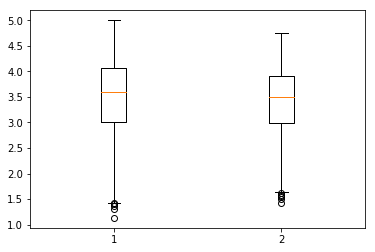

3.388601360603814
3.424377899577682
None
None


In [7]:
#boxplot
elite_reviews = df.loc[df['Elite_Reviewer'] == True]['critical_index']
reviews = df.loc[df['Elite_Reviewer'] == False]['critical_index']

data = [reviews, elite_reviews]
fig, ax = plt.subplots()
ax.boxplot(data)
plt.show()

elite_sentiment = np.mean(elite_reviews)
not_elite_sentiment = np.mean(reviews)

print(elite_sentiment)
print(not_elite_sentiment)

**Linear Regression**

In [9]:
smf.glm?

In [11]:
df.head()

,Unnamed: 0_x,average_stars,elite,review_count,user_id,Unnamed: 0_y,date,review_id,stars,text,Elite_Reviewer,critical_index
0,4.0,4.08,"[2015, 2016, 2017, 2018]",361.0,MM4RJAeH6yuaN8oZDSt0RA,10232,2017,dLOTJm1mZA1cErGSSK_N7w,3.0,"So, Mom and Dad live in Sun City and this rest...",1,3.074675
1,27.0,4.16,"[2016, 2017]",167.0,djQLJTLA4Tx7TpzYCKIqJQ,10857,2014,cJ0Zfj6jqSDtiLondkMfWw,5.0,"Cheap, clean, well maintained and good service...",0,4.291667
2,39.0,3.64,"[2016, 2017, 2018]",318.0,AsYMm_O4H-mwmWbmeACDHw,7161,2015,khzlXZYDJ_lHyrxMAxnQWg,5.0,"Excellent resort, we had a great view on the 2...",0,4.186232
3,89.0,3.80,"[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...",1090.0,Ar3bat-NGasrXDiS7WF8OA,10341,2016,h4Fr7P2sPWo0Q81Lw-xohQ,4.0,Solid 4 Stars...When leaving the establishment...,1,3.689360
4,106.0,4.30,"[2012, 2013, 2014, 2016, 2017, 2018]",398.0,i_EASSNcEqc1JrfdBjBeVw,15264,2013,VMaX2uXSEX3g9NvnoDM_aA,4.0,"I went for lunch with a friend, since she had ...",1,3.586310


In [14]:
res_1 = smf.glm("Elite_Reviewer ~ critical_index + sentiment_index", data = df, family=sm.families.Binomial()).fit()
res_1.summary()
# print(res_1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         Elite_Reviewer   No. Observations:                  790
Model:                            GLM   Df Residuals:                      788
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -383.80
Date:                Tue, 19 Mar 2019   Deviance:                       767.60
Time:                        12:59:02   Pearson chi2:                     790.
No. Iterations:                     4   Covariance Type:             nonrobust
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.7223      0.475      3.626      0.000       0.791       2.653
critical_index    -0.0797      0.136     -0.584      0.559      -0.347       0.188
==================================================================================
"""

# 4. Conclusions:

# 5. Future Work:

# 6. Resources: